# Importing Libraries

In [13]:
%matplotlib inline
import joblib
import os
import shutil
import random
import torch
import torchvision
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

#print('Using PyTorch version', torch.__version__)

# Creating Custom Dataset

In [14]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Image Transformations

In [15]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Prepare DataLoader

In [16]:
train_dirs = {
    'normal': 'COVID-19 Radiography Database/normal',
    'viral': 'COVID-19 Radiography Database/viral',
    'covid': 'COVID-19 Radiography Database/covid'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 10192 normal examples
Found 1345 viral examples
Found 3616 covid examples


In [17]:
test_dirs = {
    'normal': 'COVID-19 Radiography Database/test/normal',
    'viral': 'COVID-19 Radiography Database/test/viral',
    'covid': 'COVID-19 Radiography Database/test/covid'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'COVID-19 Radiography Database/test/normal'

In [ ]:
test_dataset

In [20]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
# print('Number of test batches', len(dl_test))

Number of training batches 2526


In [ ]:
dl_test

# Data Visualization

In [18]:
class_names = train_dataset.class_names


def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

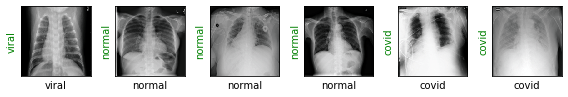

In [21]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

In [ ]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Creating the Model

In [ ]:
resnet18 = torchvision.models.resnet18(pretrained=True)

print(resnet18)

In [ ]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [ ]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

# Training the Model

In [ ]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train()

                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

In [ ]:
%%time

train(epochs=1)

# Final Results

In [ ]:
show_preds()

# Done l

In [ ]:
def show_preds1(img):
    resnet18.eval()
    outputs = resnet18(img)
    _, preds = torch.max(outputs, 1)
    if(preds==0):
        print("Normal")
    elif(preds==1):
        print("Pneumonia")
    elif(preds==2):
         print("Covid-19")
#     print(preds)

In [ ]:
def final_classn(user_image):
    img=Image.open(user_image).convert("RGB")
    img_trans=test_transform(img)
    batch_single=torch.unsqueeze(img_trans,0)
    show_preds1(batch_single)

In [ ]:
final_classn("Viral Pneumonia (59).png")

In [ ]:
filename="resnet18.sav"
joblib.dump(resnet18,filename)